Implement this procedure:


- Split the data into an auxiliary sample $D_a$ and a main sample $D_m$.
- Train an honest causal forest $F$ on the auxiliary data $D_a$.
- Take a bootstrap sample $D^BS_m$ from the main sample.
- Compute the SHAP values for the conditional ITT for each instance in $D^BS_m$ using the forest $F$.
- Compute the proportion of instances in $D^BS_m$ for which the SHAP value of age is the largest among all features.
- Repeat steps 3-5 $B$ times and record Q5, the median, and Q95 of the proportions.
- Repeat the procedure for $K$ different splits.

### Imports and set up

In [14]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from econml.grf import CausalForest
from shap.explainers import _tree # imports local fork

In [2]:
# import data
data = pd.read_csv('jtpa_doubleclean.csv') 

# get X
features = ['afdc', 'sex', 'married', 'pbhous', 'hsorged', 'black', 'hispanic', 'wkless13','age', 'prevearn']
X = data[features + ["assignmt"]]
y = data['earnings']

### Bootstrap the test set for given tE

In [30]:
def inner_bootstrap(test_SHAP, iterations):
    results = []
    # get bootstrap of test sample
    for i in range(iterations):
        # get bootstrap sample of rows in test_SHAP
        bootstrap_SHAP = test_SHAP[np.random.choice(test_SHAP.shape[0], test_SHAP.shape[0], replace=True)]
        # get proportion of observations for which age is most important feature
        prop_age_largest = sum(bootstrap_SHAP.argmax(axis=1) == 8)/bootstrap_SHAP.shape[0]
        results.append(prop_age_largest)
    return results

def outer_split(data, splits = 10, inner_iterations = 1000):
    split_df = pd.DataFrame()
    for k in tqdm(range(splits)):
        # split data
        train, test = train_test_split(data, test_size=0.5)
        # fit causal forest
        cf = CausalForest(min_samples_leaf=10)
        cf.fit(X = train[features], T = train["assignmt"], y = train["earnings"])
        # get SHAP values
        treeExplainer = _tree.TreeExplainer(cf)
        # get oob samples from cf: %todo: try this.
        test_SHAP = treeExplainer.shap_values(test[features]) # bootstrap SHAP values themselves
        # get proportion of observations for which age is most important feature
        results = inner_bootstrap(test_SHAP, inner_iterations)
        split_df[f"split_{k}"] = results
    return split_df


In [83]:
# run for single split
results = outer_split(data, splits = 50, inner_iterations=1000)

100%|██████████| 50/50 [02:42<00:00,  3.25s/it]


In [84]:
results.mean()

split_0     0.249509
split_1     0.244564
split_2     0.207468
split_3     0.168815
split_4     0.129106
split_5     0.221402
split_6     0.222256
split_7     0.137428
split_8     0.131836
split_9     0.118020
split_10    0.111222
split_11    0.187378
split_12    0.226257
split_13    0.213999
split_14    0.130808
split_15    0.208272
split_16    0.154244
split_17    0.147841
split_18    0.143915
split_19    0.187824
split_20    0.241813
split_21    0.229435
split_22    0.180778
split_23    0.183694
split_24    0.180331
split_25    0.194669
split_26    0.234839
split_27    0.223509
split_28    0.226126
split_29    0.275978
split_30    0.245881
split_31    0.199335
split_32    0.176805
split_33    0.167778
split_34    0.329402
split_35    0.200420
split_36    0.229210
split_37    0.175422
split_38    0.214180
split_39    0.327303
split_40    0.157986
split_41    0.175074
split_42    0.220630
split_43    0.133503
split_44    0.205712
split_45    0.177995
split_46    0.221638
split_47    0

for a single split

In [152]:
p = np.array(results.iloc[:,44])
p.mean()

0.20571182266009852

In [153]:
# sample size is 0.5 total length
sample_size = 0.5*data.shape[0]
sample_size

4871.5

In [154]:
p.std(), ((p.mean()*(1-p.mean()))/4871)**0.5

(0.005710024268357349, 0.005791747374228375)

In [155]:
# get theoretical coverage
theory_low = p.mean() - 1.64*((p.mean()*(1-p.mean()))/4871)**0.5
theory_high = p.mean() + 1.64*((p.mean()*(1-p.mean()))/4871)**0.5
theory_low, theory_high

sum((p > theory_low) & (p < theory_high))/len(p)

0.921

In [125]:
theory_low, theory_high

(0.1943599978066109, 0.21706364751358614)

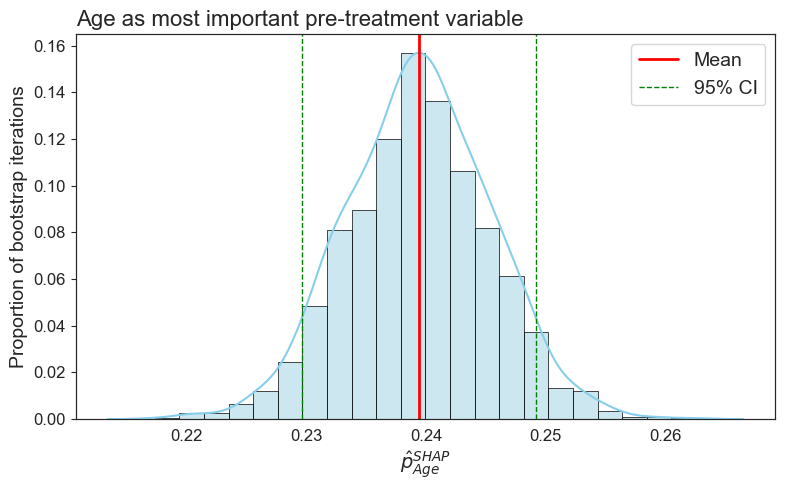

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns


vec = results.iloc[:,1]
# plot bar with 95 ci
plt.figure(figsize=(8,5))

# Set a style and palette
sns.set_style("white")

# Plot density of vec and 95% CI
sns.histplot(vec, bins = 22, color="lightblue", linewidth=0.5, alpha = 0.6, edgecolor = 'black', stat="probability")

ax1 = plt.gca()
# Get twin ax
ax = ax1.twinx()
sns.kdeplot(vec, ax = ax, color="skyblue")
# hidy second y axis
ax.get_yaxis().set_visible(False)

# Add mean line
mean_line = plt.axvline(vec.mean(), color='red', linewidth=2)

# Add empirical 5th percentile and 95th percentile lines
ci_lower = plt.axvline(vec.quantile(0.05), color='green', linewidth=1, linestyle='--')
ci_upper = plt.axvline(vec.quantile(0.95), color='green', linewidth=1, linestyle='--')


# Add labels and title
ax1.set_xlabel(r"$\hat{p}_{Age}^{SHAP}$", fontsize =14)
ax1.set_ylabel('Proportion of bootstrap iterations', fontsize = 14)
ax1.set_title('Age as most important pre-treatment variable', loc = "left", fontsize = 16)
# increase xticks fontsize
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Add a legend
plt.legend([mean_line, ci_lower], ['Mean', '95% CI'], fontsize = 14)

plt.tight_layout()

# save
plt.savefig("bootstrap_age_new.pdf", format = "pdf", dpi = 400)

plt.show()

across all splits

In [90]:
# take Q5, Median, Q95
s = results.quantile([0.05, 0.5, 0.95], axis = 0)
s

,split_0,split_1,split_2,split_3,split_4,split_5,split_6,split_7,split_8,split_9,...,split_40,split_41,split_42,split_43,split_44,split_45,split_46,split_47,split_48,split_49
0.05,0.239532,0.234195,0.197865,0.160294,0.121305,0.211823,0.212438,0.129310,0.123563,0.110222,...,0.149836,0.166051,0.210991,0.124795,0.196429,0.168924,0.211617,0.291256,0.171798,0.247537
0.50,0.249589,0.244561,0.207307,0.168719,0.129105,0.221470,0.222291,0.137110,0.131979,0.118021,...,0.157841,0.175287,0.220443,0.133415,0.205870,0.178161,0.221572,0.302545,0.181240,0.257902
0.95,0.259452,0.255347,0.217570,0.177545,0.136905,0.230501,0.232348,0.145946,0.139583,0.125421,...,0.167077,0.183908,0.230501,0.141831,0.214901,0.186782,0.231127,0.313629,0.190271,0.268268


In [94]:
# get summary
q = s.median(axis = 1)
q

0.05    0.190163
0.50    0.199815
0.95    0.209467
dtype: float64

In [96]:
q[0.05], q[0.95]

(0.19016317733990146, 0.2094673645320197)

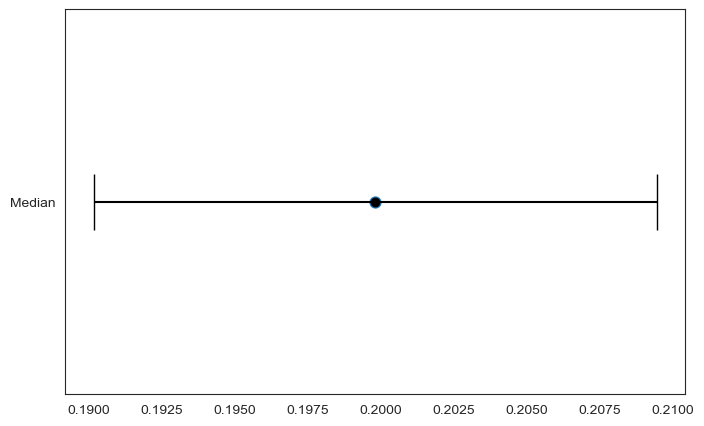

In [107]:
# plot the above in boxplot
plt.figure(figsize=(8,5))

plot_data = pd.Series({"Median": q[0.50]})

# plot summary box
sns.pointplot(data=plot_data, orient="h")
# add errorbar errorbar = (lambda x: (q[0.05], q[0.95]))
plt.errorbar(y = "Median", x = q[0.50], xerr = [[q[0.50] - q[0.05]], [q[0.95] - q[0.50]],], fmt='o', color='black', capsize=20)
plt.show()

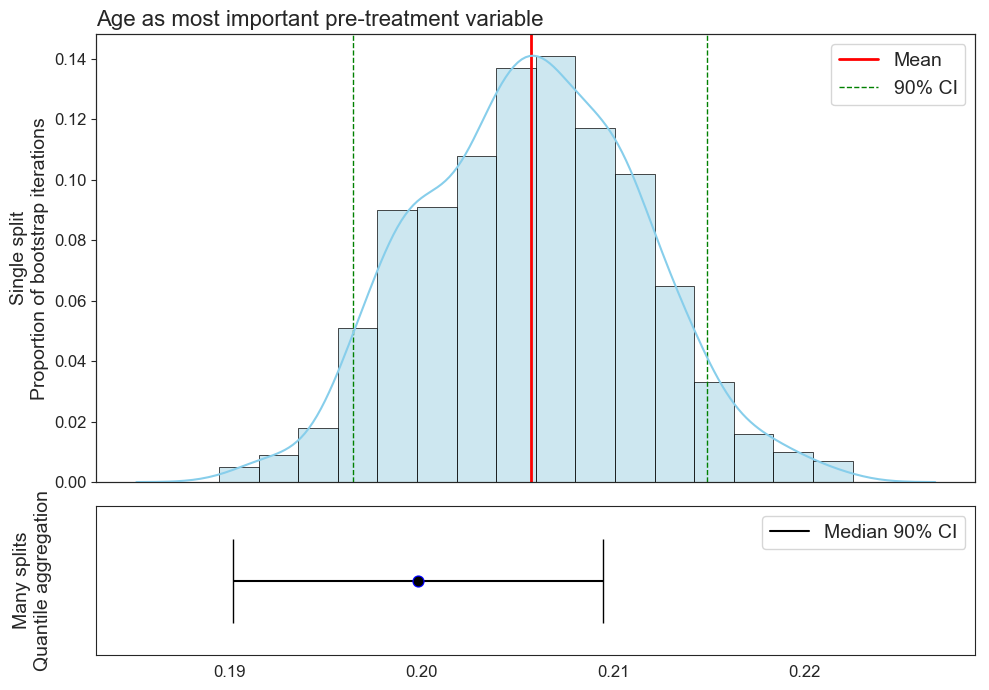

In [149]:
# put the two plots together
from matplotlib.lines import Line2D

f, axs = plt.subplots(2, 1, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

vec = results.iloc[:,44]
# Set a style and palette
sns.set_style("white")

# Plot density of vec and 95% CI
sns.histplot(vec, bins = 16, color="lightblue", linewidth=0.5, alpha = 0.6, edgecolor = 'black', stat="probability", ax = axs[0])

ax = axs[0].twinx()
sns.kdeplot(vec, ax = ax, color="skyblue")
# hidy second y axis
ax.get_yaxis().set_visible(False)

# Add mean line
mean_line = axs[0].axvline(vec.mean(), color='red', linewidth=2)

# Add empirical 5th percentile and 95th percentile lines
ci_lower = axs[0].axvline(vec.quantile(0.05), color='green', linewidth=1, linestyle='--')
ci_upper = axs[0].axvline(vec.quantile(0.95), color='green', linewidth=1, linestyle='--')


# Add labels and title
axs[0].set_xlabel(r"$\hat{p}_{Age}^{SHAP}$", fontsize =14)
axs[0].set_ylabel('Single split\nProportion of bootstrap iterations', fontsize = 14)
axs[0].set_title('Age as most important pre-treatment variable', loc = "left", fontsize = 16)
# increase xticks fontsize
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Add a legend
axs[0].legend([mean_line, ci_lower], ['Mean', '90% CI'], fontsize = 14)

# add summary CI
plot_data = pd.Series({" ": q[0.50]})

# add errorbar errorbar = (lambda x: (q[0.05], q[0.95]))
axs[1].errorbar(y = " ", x = q[0.50], xerr = [[q[0.50] - q[0.05]], [q[0.95] - q[0.50]],], 
                fmt='o', color='black', capsize=30, label = "Median 90% CI")
# plot summary box
sns.pointplot(data=plot_data, orient="h", ax = axs[1], color = "blue")
axs[1].set_ylabel("Many splits\nQuantile aggregation", fontsize = 14, labelpad = 22)

# Adjust the size of the legend marker
# Create a custom legend handle
legend_handle = Line2D([0], [0], color='black', lw=1.5)
axs[1].legend([legend_handle], ['Median 90% CI'], fontsize=14)
axs[1].tick_params(axis="x", labelsize = 12)


plt.tight_layout()

# save
plt.savefig("bootstrap_age_new.pdf", format = "pdf", dpi = 400)

plt.show()


### Bootstrap the train data and take OOB

I rethought this procedure. The two level structure doesnt make much sense.
1. take bootstrap sample from data
2. train cf and get shap Explanation object for BS sample
3. get proportion on out-of-BS-sample data

In [5]:
def new_bootstrap_loop(data, n_loops = 10):
    results = []
    for i in tqdm(range(n_loops)):
        # get bootstrap sample as training data, and unselected data as inference data
        train = data.sample(replace = True, n = int(data.shape[0]*(3/4)))
        test = data.loc[~data.index.isin(train.index)]
        # get X,y
        X_train = train[features + ["assignmt"]]
        y_train = train['earnings']
        # train cf
        causal_forest = CausalForest(min_samples_leaf=4, honest=True)
        causal_forest.fit(X_train[features], X_train['assignmt'], y_train)
        # get tE
        tE = _tree.TreeExplainer(causal_forest)
        # get SHAP values and proportion
        shap_values = tE.shap_values(test[features])
        prop_age_largest = sum(shap_values.argmax(axis=1) == 8)/shap_values.shape[0]
        results.append(prop_age_largest)
    return results

    

In [41]:
# example of sizes
train = data.sample(replace = True, n = int(data.shape[0]*(3/4)))
test = data.loc[~data.index.isin(train.index)]
test.shape

(4545, 26)

In [62]:
results = new_bootstrap_loop(data, n_loops = 6)

Loop 0 took 9.398887872695923 seconds
Loop 1 took 9.661894798278809 seconds
Loop 2 took 9.555810928344727 seconds
Loop 3 took 9.617213010787964 seconds
Loop 4 took 9.840630054473877 seconds
Loop 5 took 10.150930881500244 seconds


In [10]:
results

,Iteration_0,Iteration_1,Iteration_2,Iteration_3,Iteration_4,Iteration_5,Iteration_6,Iteration_7,Iteration_8,Iteration_9,...,Iteration_190,Iteration_191,Iteration_192,Iteration_193,Iteration_194,Iteration_195,Iteration_196,Iteration_197,Iteration_198,Iteration_199
0,0.206076,0.198481,0.150452,0.19725,0.225985,0.208539,0.20197,0.182882,0.223112,0.236453,...,0.244048,0.200534,0.203818,0.250616,0.191708,0.174056,0.210591,0.180829,0.208333,0.221264


In [22]:
results.to_csv("new_bootstrap_results.csv")

In [3]:
#read results
results = pd.read_csv("bootstrap_results_age3.csv", index_col=0)

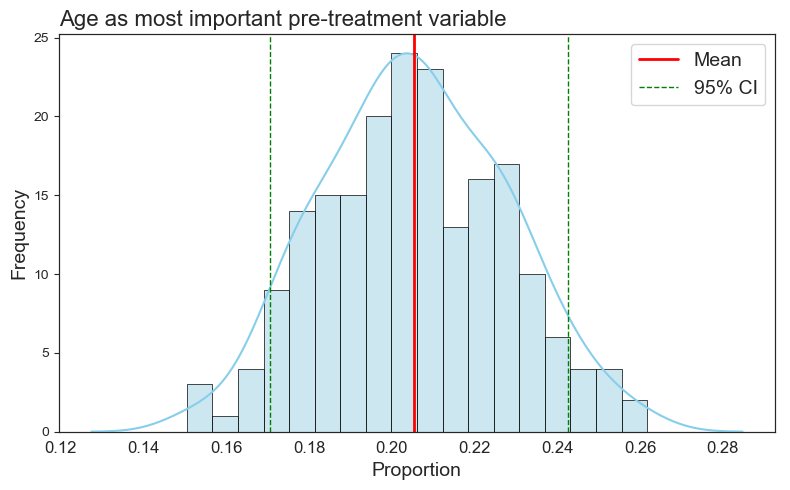

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


vec = results.iloc[0,:]
# plot bar with 95 ci
plt.figure(figsize=(8,5))

# Set a style and palette
sns.set_style("white")

# Plot density of vec and 95% CI
sns.histplot(vec, bins = 18, color="lightblue", linewidth=0.5, alpha = 0.6, edgecolor = 'black')

ax1 = plt.gca()
# Get twin ax
ax = ax1.twinx()
sns.kdeplot(vec, ax = ax, color="skyblue")
# hidy second y axis
ax.get_yaxis().set_visible(False)

# Add mean line
mean_line = plt.axvline(vec.mean(), color='red', linewidth=2)

# Add empirical 5th percentile and 95th percentile lines
ci_lower = plt.axvline(vec.quantile(0.05), color='green', linewidth=1, linestyle='--')
ci_upper = plt.axvline(vec.quantile(0.95), color='green', linewidth=1, linestyle='--')


# Add labels and title
ax1.set_xlabel('Proportion', fontsize =14)
ax1.set_ylabel('Frequency', fontsize = 14)
ax1.set_title('Age as most important pre-treatment variable', loc = "left", fontsize = 16)
# increase xticks fontsize
ax1.tick_params(axis='x', labelsize=12)

# Add a legend
plt.legend([mean_line, ci_lower], ['Mean', '95% CI'], fontsize = 14)

plt.tight_layout()

# save
plt.savefig("bootstrap_age3.pdf", format = "pdf", dpi = 400)

plt.show()

In [46]:
vec.mean()

0.20543821839080453

In [47]:
low_ci, up_ci, up_ci - low_ci

(0.161932338890442, 0.24894409789116706, 0.08701175900072505)

In [42]:
sample_size = 4600 # apprixmate sample size for test set

theory_low = vec.mean() - (0.2*(0.8)/sample_size)**0.5
theory_high = vec.mean() + (0.2*(0.8)/sample_size)**0.5

In [48]:
vec.std(), ((0.2*0.8)/sample_size)**0.5

(0.022196877296103326, 0.005897678246195886)

In [29]:
# get CI based on normal 
low_ci = vec.mean() - 1.96*vec.std()
up_ci = vec.mean() + 1.96*vec.std()

# get coverage of emp var CI
sum((vec > low_ci) & (vec < up_ci))/len(vec)

0.955

In [45]:
# get coverate of theoretical CI
sum((vec > theory_low) & (vec < theory_high))/len(vec)

0.21

The reason for this high variance is that the draws are not iid across splits, this is ignoring the split induced variance in p.

### Binomial experiment

In [17]:
import numpy as np

# sample 1000 bernoulli trials with p = 0.2
p = []
n = 200

for i in range(n):
    sample = np.random.binomial(1, 0.2, 1000)
    p.append(sum(sample)/len(sample))



In [18]:
p = np.array(p)
p.mean()

0.19978

In [19]:
p.std()

0.012857355871251289

In [20]:
((0.2*0.8)/1000)**0.5

0.01264911064067352